In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir='/content/drive/MyDrive/hand-gestures/images/images'
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 132 files belonging to 9 classes.
Using 106 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 132 files belonging to 9 classes.
Using 26 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['call', 'dislike', 'fist', 'four', 'like', 'ok', 'one', 'peace', 'stop']


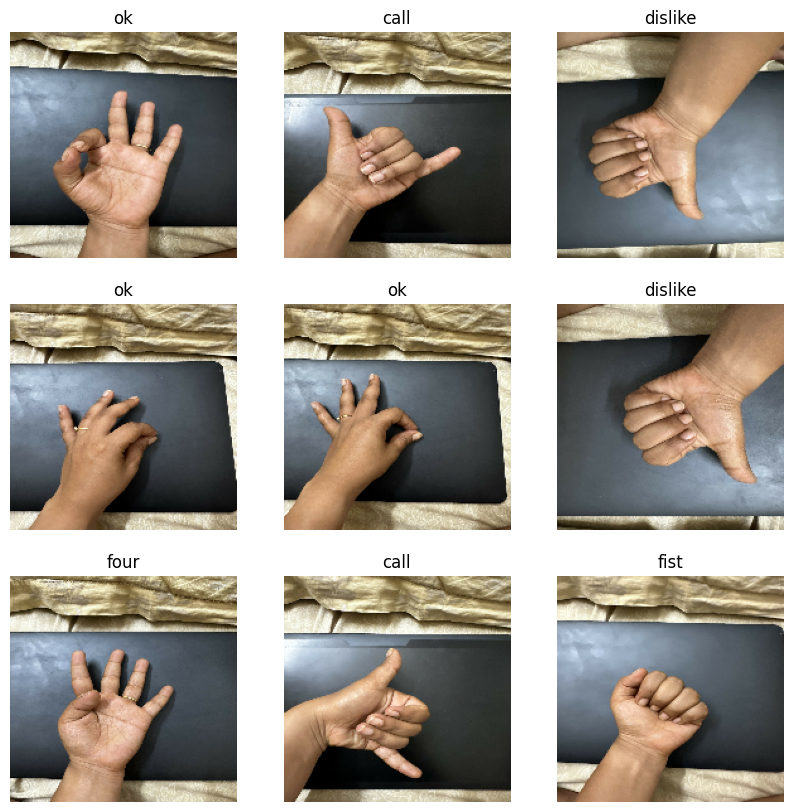

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 16)        4

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
4/4 [==============================] - 19s 3s/step - loss: 2.1765 - accuracy: 0.1038 - val_loss: 2.2172 - val_accuracy: 0.1154
Epoch 2/10
4/4 [==============================] - 0s 23ms/step - loss: 1.9914 - accuracy: 0.3396 - val_loss: 2.2668 - val_accuracy: 0.1923
Epoch 3/10
4/4 [==============================] - 0s 27ms/step - loss: 1.6493 - accuracy: 0.5472 - val_loss: 1.8760 - val_accuracy: 0.4615
Epoch 4/10
4/4 [==============================] - 0s 19ms/step - loss: 1.1641 - accuracy: 0.7453 - val_loss: 1.0772 - val_accuracy: 0.6538
Epoch 5/10
4/4 [==============================] - 0s 24ms/step - loss: 0.7421 - accuracy: 0.7925 - val_loss: 0.6782 - val_accuracy: 0.8462
Epoch 6/10
4/4 [==============================] - 0s 23ms/step - loss: 0.4375 - accuracy: 0.9057 - val_loss: 0.6031 - val_accuracy: 0.8462
Epoch 7/10
4/4 [==============================] - 0s 17ms/step - loss: 0.2819 - accuracy: 0.9151 - val_loss: 0.4838 - val_accuracy: 0.8077
Epoch 8/10
4/4 [============

In [ ]:
import pickle

filename = '/content/drive/MyDrive/hand-gestures/model/final_hand_gesture_model.pk'
pickle.dump(model, open(filename, 'wb'))

# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
call_path = '/content/drive/MyDrive/hand-gestures/images/images/one/IMG_3792.jpg'

img = tf.keras.utils.load_img(
    call_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 191ms/step
This image most likely belongs to one with a 99.00 percent confidence.
